# Import Required Libraries

In [1]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")

# Select Randomness

In [2]:
seed_constant = 5
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

# View the dataset

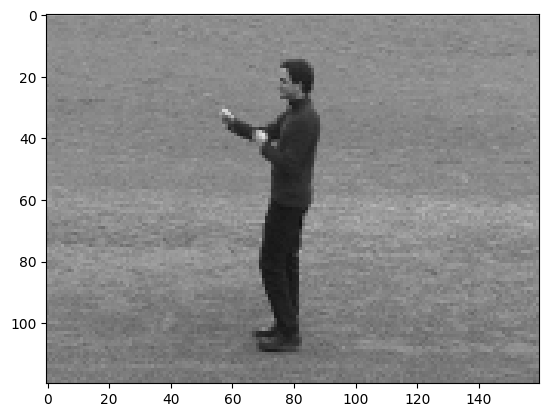

Finished processing folder: boxing


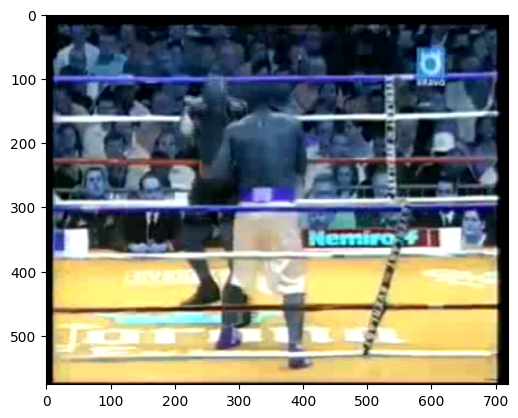

Finished processing folder: fights


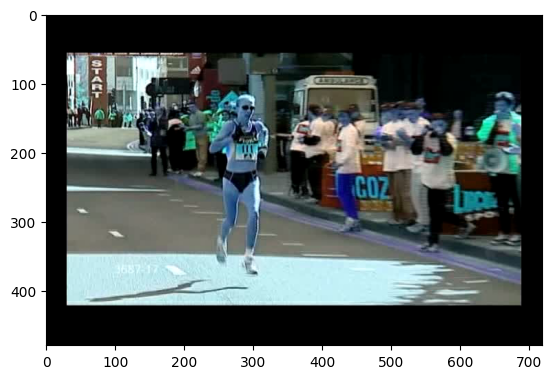

Finished processing folder: noFights


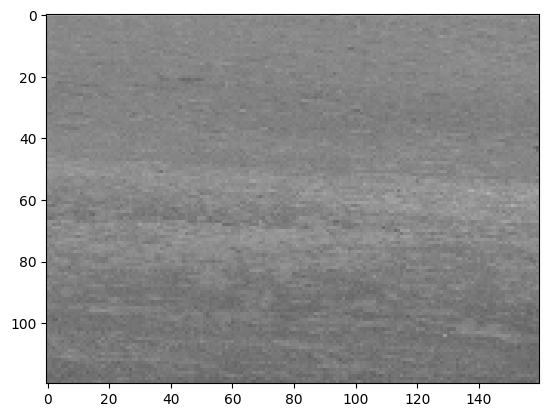

Finished processing folder: running


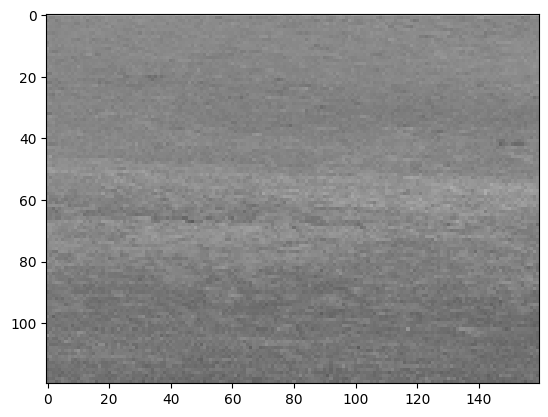

Finished processing folder: walking


In [3]:
dataset_path = (r"C:\Users\PC\Desktop\Apps\Suspicious-Human-Activity-Detection-LRCN\Suspicious-Human-Activity-Detection-LRCN\Datasets")
num_frames_to_extract = 1

def extract_and_display_frames(video_path, num_frames):
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"Error opening video: {video_path}")
        return
    frame_count = 0
    while frame_count < num_frames:
        ret, frame = cap.read()
        if not ret:
            print(f"Error reading frame {frame_count} from video: {video_path}")
            break
        plt.imshow(frame)
        plt.show()
        frame_count += 1
    cap.release()

for folder_name in os.listdir(dataset_path):
    folder_path = os.path.join(dataset_path, folder_name)

    if not os.path.isdir(folder_path):
        continue
    video_files = [f for f in os.listdir(folder_path) if f.lower().endswith((".mp4", ".avi", ".mov",".mpg"))]

    if not video_files:
        print(f"No video files found in folder: {folder_path}")
        continue
    first_video_path = os.path.join(folder_path, video_files[0])
    extract_and_display_frames(first_video_path, num_frames_to_extract)
    print(f"Finished processing folder: {folder_name}")


# Set Dataset Variables

In [4]:
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
SEQUENCE_LENGTH = 30
DATASET_DIR = dataset_path
CLASSES_LIST = ["boxing", "fights", "noFights","running","walking"]

# Data pre-processing

In [5]:
def frames_extraction(video_path):
    frames_list = []
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)
    for frame_counter in range(SEQUENCE_LENGTH):
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window) 
        success, frame = video_reader.read() 
        if not success:
            break
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255
        frames_list.append(normalized_frame)
    video_reader.release()
    return frames_list

In [6]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    for class_index, class_name in enumerate(CLASSES_LIST):
        print(f'Extracting Data of Class: {class_name}')
        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)
    features = np.asarray(features)
    labels = np.array(labels)  
    return features, labels, video_files_paths

In [7]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: boxing
Extracting Data of Class: fights
Extracting Data of Class: noFights
Extracting Data of Class: running
Extracting Data of Class: walking


In [12]:
one_hot_encoded_labels = to_categorical(labels)

In [13]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.25, shuffle = True, random_state = seed_constant)
features = None
labels = None

# Model Creation LRCN (Long-term Recurrent Convolutional Network)

In [14]:
def create_LRCN_model():
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same',activation = 'relu'), input_shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    
    model.add(TimeDistributed(Conv2D(128, (3, 3), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Conv2D(256, (2, 2), padding='same',activation = 'relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
                                      
    model.add(TimeDistributed(Flatten()))
                                      
    model.add(LSTM(32))
                                      
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    
    return model

In [15]:
model = create_LRCN_model()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 30, 64, 64, 32)    896       
 ributed)                                                        
                                                                 
 time_distributed_1 (TimeDi  (None, 30, 16, 16, 32)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 30, 16, 16, 64)    18496     
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 30, 4, 4, 64)      0         
 stributed)                                                      
                                                                 
 time_distributed_4 (TimeDi  (None, 30, 4, 4, 128)    

In [23]:
plot_model(model, to_file = 'Suspicious_Human_Activity_LRCN_Model.png', show_shapes = True, show_layer_names = True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


# Model Training

In [16]:
early_stopping_callback = EarlyStopping(monitor = 'accuracy', patience = 10, mode = 'max', restore_best_weights = True)
model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ["accuracy"])
model_training_history = model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4 , shuffle = True, validation_split = 0.25, callbacks = [early_stopping_callback])


Epoch 1/70


71/71 [==============================] - 35s 384ms/step - loss: 1.3396 - accuracy: 0.4164 - val_loss: 1.3328 - val_accuracy: 0.4043
Epoch 2/70
71/71 [==============================] - 17s 239ms/step - loss: 1.1009 - accuracy: 0.5445 - val_loss: 0.7290 - val_accuracy: 0.7234
Epoch 3/70
71/71 [==============================] - 23s 319ms/step - loss: 0.7108 - accuracy: 0.7473 - val_loss: 0.5771 - val_accuracy: 0.7553
Epoch 4/70
71/71 [==============================] - 17s 243ms/step - loss: 0.5234 - accuracy: 0.7722 - val_loss: 0.5837 - val_accuracy: 0.7660
Epoch 5/70
71/71 [==============================] - 15s 216ms/step - loss: 0.4930 - accuracy: 0.7651 - val_loss: 0.4821 - val_accuracy: 0.7340
Epoch 6/70
71/71 [==============================] - 14s 197ms/step - loss: 0.4187 - accuracy: 0.8327 - val_loss: 0.3921 - val_accuracy: 0.8511
Epoch 7/70
71/71 [==============================] - 18s 252ms/step - loss: 0.3677 - accuracy: 0.8470 - val_loss: 0.4717 - val_accuracy: 0.7

# Save Model

In [17]:
model.save("Suspicious_Human_Activity_Detection_LRCN_Model.h5")

# Plot Loss and Accuracy Graphs while Training

In [18]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    epochs = range(len(metric_value_1))
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    plt.title(str(plot_name))
    plt.legend()

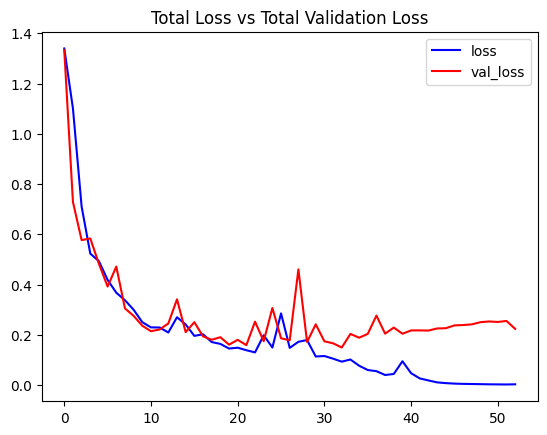

In [19]:
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

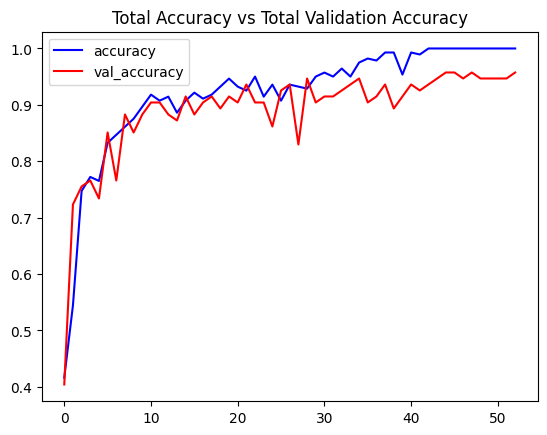

In [20]:
plot_metric(model_training_history, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')

# Accuracy on Test Dataset

In [21]:
acc = 0
for i in range(len(features_test)):
  predicted_label = np.argmax(model.predict(np.expand_dims(features_test[i],axis =0))[0])
  actual_label = np.argmax(labels_test[i])
  if predicted_label == actual_label:
      acc += 1
acc = (acc * 100)/len(labels_test)
print("Accuracy =",acc)

1/1 [==============================] - 0s 51ms/step
Accuracy = 91.2


# Load Model

In [22]:
model = load_model('Suspicious_Human_Activity_Detection_LRCN_Model.h5')

# All Action Prediction in Video

In [24]:
import cv2
import numpy as np
from moviepy.editor import VideoFileClip

def predict_on_video(video_file_path, output_file_path, sequence_length, image_height, image_width, model, classes_list):
    video_reader = cv2.VideoCapture(video_file_path)
    if not video_reader.isOpened():
        print(f"Error opening video: {video_file_path}")
        return

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = video_reader.get(cv2.CAP_PROP_FPS)

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_file_path, fourcc, fps, (original_video_width, original_video_height))

    frames_queue = []  
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (image_height, image_width))
        normalized_frame = resized_frame / 255

        frames_queue.append(normalized_frame)

        if len(frames_queue) == sequence_length:
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = classes_list[predicted_label]

            frames_queue = frames_queue[1:] 

        cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [25]:
video_file_path = r"D:\External_Projects\Suspicious-Human-Activity-Detection-LRCN\Datasets\boxing\person20_boxing_d3_uncomp.avi"

In [26]:
video_name = os.path.splitext(os.path.basename(video_file_path))[0]
output_file_path = "D:\\External_Projects\\Suspicious-Human-Activity-Detection-LRCN\\Prediction_output"+ f"\\{video_name}.avi"
predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, model, CLASSES_LIST)
clip = VideoFileClip(output_file_path).without_audio()
clip.ipython_display()

Error opening video: D:\External_Projects\Suspicious-Human-Activity-Detection-LRCN\Datasets\boxing\person20_boxing_d3_uncomp.avi


OSError: MoviePy error: the file D:\External_Projects\Suspicious-Human-Activity-Detection-LRCN\Prediction_output\person20_boxing_d3_uncomp.avi could not be found!
Please check that you entered the correct path.